# Diabetes Prediction: Data Preprocessing and Feature Engineering

## 3. Data Preprocessing

In this notebook, we'll perform data preprocessing and feature engineering based on the insights gained from our exploratory data analysis.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Set plot style and size
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

# For reproducibility
np.random.seed(42)


In [3]:
# Load the balanced dataset
print("Loading dataset...")
df = pd.read_csv('data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"First 5 rows:")
df.head()


Loading dataset...
Dataset shape: (70692, 22)
First 5 rows:


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


### 3.1 Check for Missing Values

In [4]:
def check_data_quality(df):
    """
    Comprehensive data quality check function
    """
    print("\n=== DATA QUALITY REPORT ===")
    
    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n❌ Missing values found: {missing.sum()}")
        print(missing[missing > 0])
    else:
        print("\n✅ No missing values")
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"\n❌ Duplicate rows found: {duplicates}")
    else:
        print("\n✅ No duplicate rows")
    
    # Check data types
    print("\n📊 Data Types:")
    print(df.dtypes.value_counts())
    
    # Check for outliers in numerical columns
    print("\n🔍 Potential Outliers:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        if outliers > 0:
            pct = 100 * outliers / len(df)
            print(f"  - {col}: {outliers} outliers ({pct:.2f}%)")
    
    # Check class balance
    if 'Diabetes_binary' in df.columns:
        print("\n⚖️ Class Balance:")
        class_counts = df['Diabetes_binary'].value_counts()
        print(class_counts)
        print(f"Balance ratio: {class_counts.min() / class_counts.max():.4f}")
    
    # Check for zero variance features
    print("\n🔢 Zero/Low Variance Features:")
    for col in df.columns:
        if df[col].nunique() == 1:
            print(f"  - {col}: Zero variance (only one unique value)")
        elif df[col].nunique() == 2 and df[col].value_counts().min() / len(df) < 0.01:
            print(f"  - {col}: Low variance (rare class < 1%)")
    
    print("\n=== END OF REPORT ===")

# Run comprehensive data quality check
print("Checking data quality...")
check_data_quality(df)


Checking data quality...

=== DATA QUALITY REPORT ===

✅ No missing values

❌ Duplicate rows found: 1635

📊 Data Types:
float64    22
Name: count, dtype: int64

🔍 Potential Outliers:
  - CholCheck: 1749 outliers (2.47%)
  - BMI: 2181 outliers (3.09%)
  - Stroke: 4395 outliers (6.22%)
  - HeartDiseaseorAttack: 10449 outliers (14.78%)
  - Veggies: 14932 outliers (21.12%)
  - HvyAlcoholConsump: 3020 outliers (4.27%)
  - AnyHealthcare: 3184 outliers (4.50%)
  - NoDocbcCost: 6639 outliers (9.39%)
  - MentHlth: 11816 outliers (16.71%)
  - PhysHlth: 10624 outliers (15.03%)

⚖️ Class Balance:
Diabetes_binary
0.0    35346
1.0    35346
Name: count, dtype: int64
Balance ratio: 1.0000

🔢 Zero/Low Variance Features:

=== END OF REPORT ===


### 3.2 Check for Duplicates

In [5]:
# Check for duplicate rows
print("Checking for duplicate rows...")
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    print("Removing duplicates...")
    df = df.drop_duplicates()
    print(f"New dataset shape after removing duplicates: {df.shape}")
else:
    print("No duplicates found.")


Checking for duplicate rows...
Number of duplicate rows: 1635
Removing duplicates...
New dataset shape after removing duplicates: (69057, 22)


### 3.3 Handle Outliers

BMI outliers (BMI > 50): 923


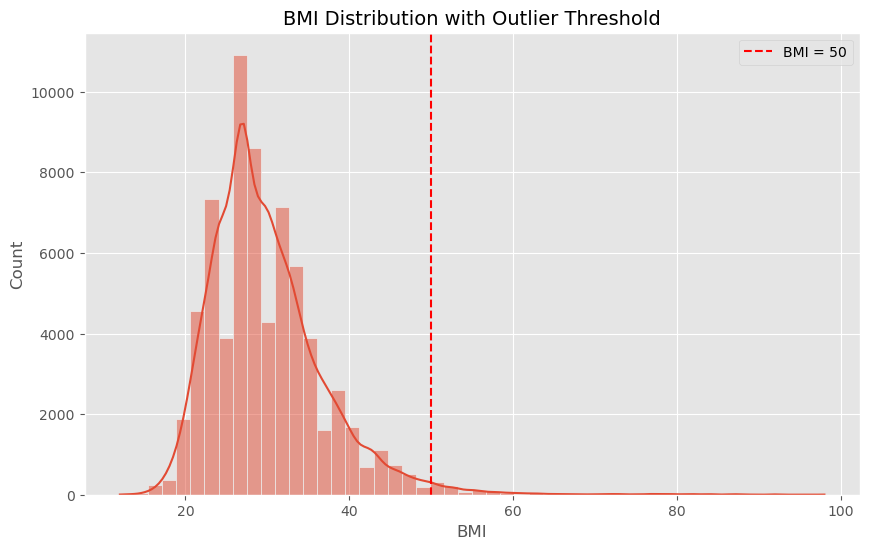

Capping BMI values at 50...
BMI values > 50 after capping: 0
Max BMI after capping: 50.0


In [6]:
# From our EDA, we identified potential outliers in BMI (values > 50)
print(f"BMI outliers (BMI > 50): {(df['BMI'] > 50).sum()}")

# Create a histogram to visualize BMI distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='BMI', bins=50, kde=True)
plt.axvline(x=50, color='red', linestyle='--', label='BMI = 50')
plt.title('BMI Distribution with Outlier Threshold', fontsize=14)
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.show()

# Decision: Cap BMI at 50 instead of removing outliers to preserve data
print("Capping BMI values at 50...")
df['BMI_original'] = df['BMI'].copy()  # Save original values
df['BMI'] = df['BMI'].clip(upper=50)

# Verify the change
print(f"BMI values > 50 after capping: {(df['BMI'] > 50).sum()}")
print(f"Max BMI after capping: {df['BMI'].max()}")


## 4. Feature Engineering



### 4.1 Create BMI Categories



Creating BMI categories...


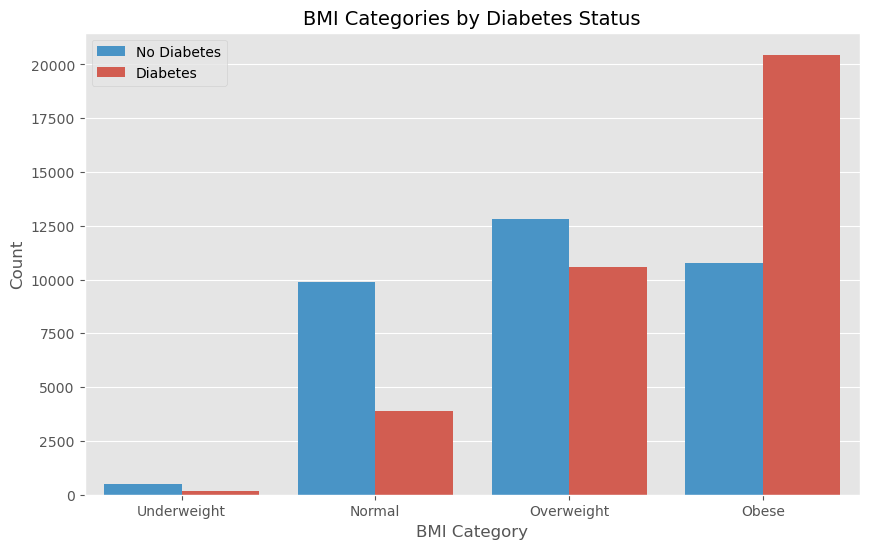

Percentage of diabetes in each BMI category:
Underweight: 26.04%
Normal: 28.37%
Overweight: 45.15%
Obese: 65.50%


In [7]:
# Create BMI categories based on standard medical definitions
print("Creating BMI categories...")
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 0  # Underweight
    elif bmi < 25:
        return 1  # Normal weight
    elif bmi < 30:
        return 2  # Overweight
    else:
        return 3  # Obese

df['BMI_Category'] = df['BMI'].apply(categorize_bmi)

# Map numeric categories to labels for visualization
bmi_category_names = {0: 'Underweight', 1: 'Normal', 2: 'Overweight', 3: 'Obese'}

# Display distribution of BMI categories
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='BMI_Category', hue='Diabetes_binary', palette=['#3498db', '#e74c3c'])
plt.title('BMI Categories by Diabetes Status', fontsize=14)
plt.xlabel('BMI Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1, 2, 3], [bmi_category_names[i] for i in range(4)])
plt.legend(['No Diabetes', 'Diabetes'])
plt.show()

# Calculate percentage of diabetes in each BMI category
print("Percentage of diabetes in each BMI category:")
for category, name in bmi_category_names.items():
    category_df = df[df['BMI_Category'] == category]
    diabetes_pct = 100 * category_df['Diabetes_binary'].mean()
    print(f"{name}: {diabetes_pct:.2f}%")


### 4.2 Create Age Groups



Creating age groups...


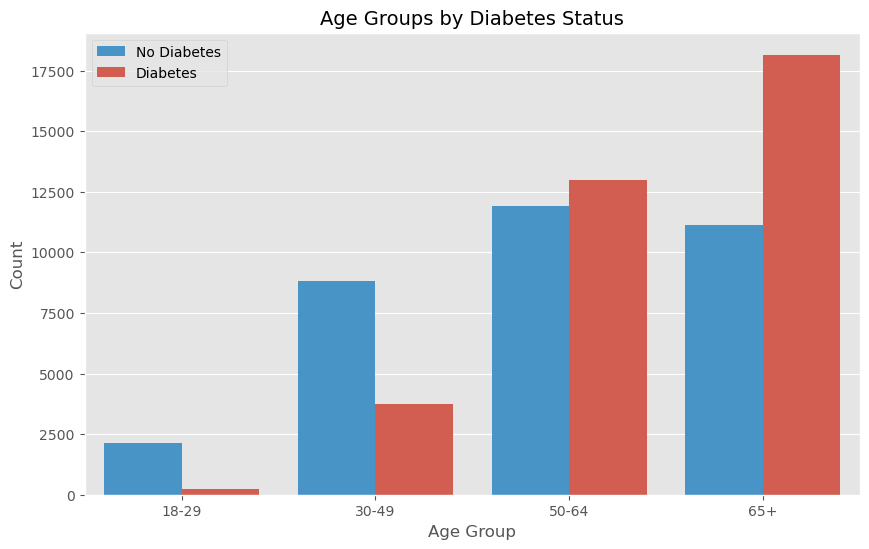

Percentage of diabetes in each age group:
18-29: 9.28%
30-49: 29.73%
50-64: 52.20%
65+: 62.03%


In [8]:
# From EDA, we know Age is a significant factor
# Create age groups based on common health risk categories
print("Creating age groups...")
def categorize_age(age_code):
    # Age codes in the dataset:
    # 1: 18-24, 2: 25-29, 3: 30-34, 4: 35-39, 5: 40-44, 6: 45-49,
    # 7: 50-54, 8: 55-59, 9: 60-64, 10: 65-69, 11: 70-74, 12: 75-79, 13: 80+
    
    if age_code <= 2:  # 18-29
        return 0  # Young adult
    elif age_code <= 6:  # 30-49
        return 1  # Adult
    elif age_code <= 9:  # 50-64
        return 2  # Middle age
    else:  # 65+
        return 3  # Senior

df['Age_Group'] = df['Age'].apply(categorize_age)

# Map numeric age groups to labels for visualization
age_group_names = {0: '18-29', 1: '30-49', 2: '50-64', 3: '65+'}

# Display distribution of age groups
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Age_Group', hue='Diabetes_binary', palette=['#3498db', '#e74c3c'])
plt.title('Age Groups by Diabetes Status', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1, 2, 3], [age_group_names[i] for i in range(4)])
plt.legend(['No Diabetes', 'Diabetes'])
plt.show()

# Calculate percentage of diabetes in each age group
print("Percentage of diabetes in each age group:")
for group, name in age_group_names.items():
    group_df = df[df['Age_Group'] == group]
    diabetes_pct = 100 * group_df['Diabetes_binary'].mean()
    print(f"{name}: {diabetes_pct:.2f}%")


### 4.3 Create Health Risk Score



Creating health risk score...


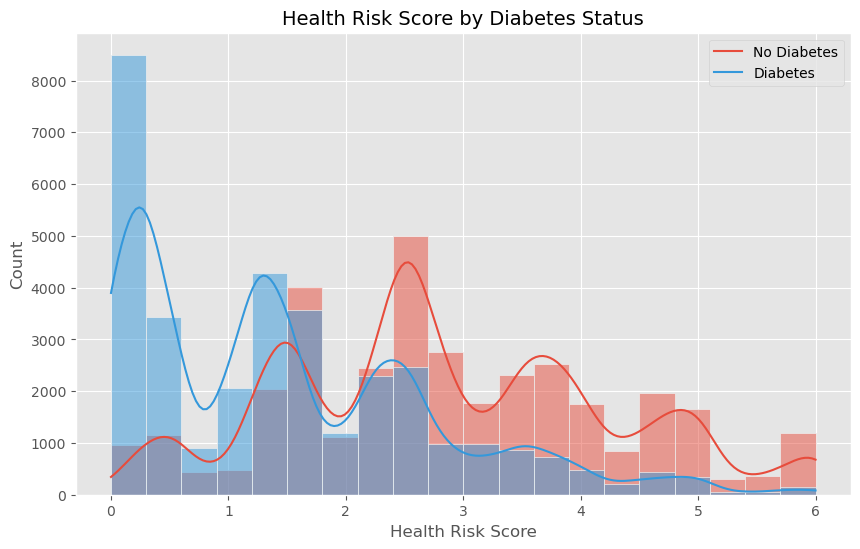

Correlation between Health Risk Score and Diabetes: 0.4640


In [9]:
# From our EDA, we identified several health indicators that correlate with diabetes
# Let's combine them into a single health risk score
print("Creating health risk score...")

# Health indicators to include (based on correlation analysis)
health_indicators = ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'GenHlth', 'DiffWalk', 'PhysHlth']

# Create a simple additive risk score
# Note: GenHlth is on a scale of 1-5 where 5 is poor health, so we'll normalize it
df['Health_Risk_Score'] = (
    df['HighBP'] + 
    df['HighChol'] + 
    df['HeartDiseaseorAttack'] + 
    (df['GenHlth'] - 1) / 4 +  # Normalize to 0-1 range
    df['DiffWalk'] + 
    np.clip(df['PhysHlth'] / 30, 0, 1)  # Normalize to 0-1 range
)

# Visualize the health risk score distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Health_Risk_Score', hue='Diabetes_binary', 
             kde=True, palette=['#3498db', '#e74c3c'], bins=20)
plt.title('Health Risk Score by Diabetes Status', fontsize=14)
plt.xlabel('Health Risk Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(['No Diabetes', 'Diabetes'])
plt.show()

# Calculate correlation with diabetes
print(f"Correlation between Health Risk Score and Diabetes: {df['Health_Risk_Score'].corr(df['Diabetes_binary']):.4f}")


### 4.4 Create Lifestyle Score



Creating lifestyle score...


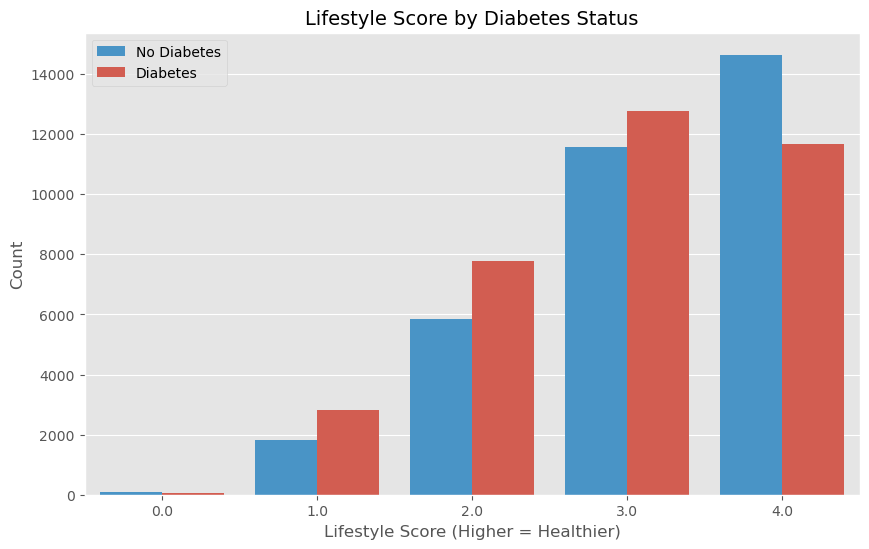

Correlation between Lifestyle Score and Diabetes: -0.1080


In [10]:
# Combine lifestyle factors that showed negative correlation with diabetes
print("Creating lifestyle score...")

# Lifestyle indicators to include (based on correlation analysis)
lifestyle_indicators = ['PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump']

# Create a simple additive lifestyle score
# Higher score means healthier lifestyle
df['Lifestyle_Score'] = (
    df['PhysActivity'] +  # 1 if physically active
    df['Fruits'] +        # 1 if consumes fruits daily
    df['Veggies'] +       # 1 if consumes vegetables daily
    (1 - df['HvyAlcoholConsump'])  # 1 if NOT a heavy drinker
)

# Visualize the lifestyle score distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Lifestyle_Score', hue='Diabetes_binary', palette=['#3498db', '#e74c3c'])
plt.title('Lifestyle Score by Diabetes Status', fontsize=14)
plt.xlabel('Lifestyle Score (Higher = Healthier)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(['No Diabetes', 'Diabetes'])
plt.show()

# Calculate correlation with diabetes
print(f"Correlation between Lifestyle Score and Diabetes: {df['Lifestyle_Score'].corr(df['Diabetes_binary']):.4f}")


## 5. Feature Selection



### 5.1 Correlation-based Selection


Feature correlations with diabetes (sorted):
Diabetes_binary         1.000000
Health_Risk_Score       0.463956
GenHlth                 0.396571
HighBP                  0.372048
BMI                     0.304231
BMI_Category            0.290867
BMI_original            0.285643
HighChol                0.281399
Age                     0.274550
Age_Group               0.270581
DiffWalk                0.267082
HeartDiseaseorAttack    0.207229
PhysHlth                0.206868
Stroke                  0.122727
CholCheck               0.118900
MentHlth                0.080688
Smoker                  0.075853
Sex                     0.042538
NoDocbcCost             0.036145
AnyHealthcare           0.027034
Fruits                 -0.044560
Veggies                -0.072181
HvyAlcoholConsump      -0.098709
Lifestyle_Score        -0.107973
PhysActivity           -0.150281
Education              -0.158522
Income                 -0.212846
Name: Diabetes_binary, dtype: float64


C:\Users\asus\AppData\Local\Temp\ipykernel_17104\379164530.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')


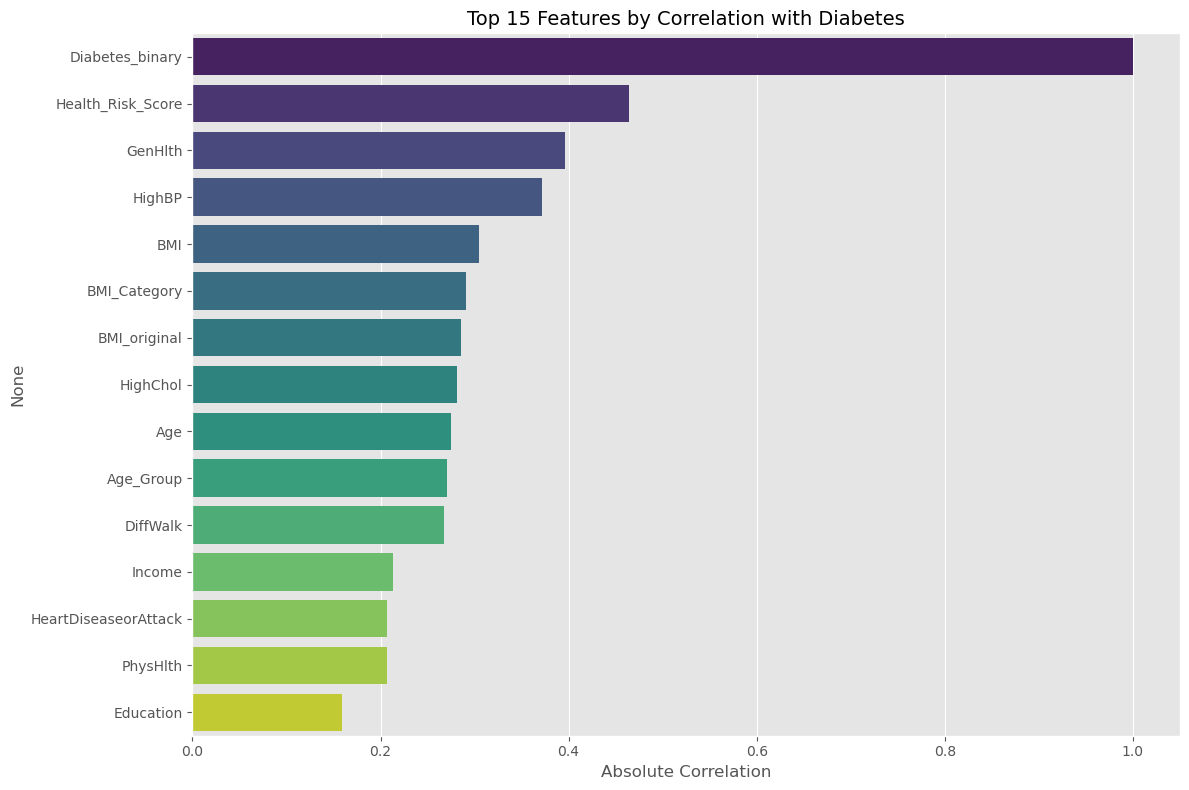

In [11]:

# Display correlations with the target variable
print("Feature correlations with diabetes (sorted):")
correlations = df.corr()['Diabetes_binary'].sort_values(ascending=False)
print(correlations)

# Visualize top 15 correlations
plt.figure(figsize=(12, 8))
top_corr = correlations.abs().sort_values(ascending=False)[:15]
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title('Top 15 Features by Correlation with Diabetes', fontsize=14)
plt.xlabel('Absolute Correlation', fontsize=12)
plt.tight_layout()
plt.show()


### 5.2 Random Forest Feature Importance



Training Random Forest for feature importance...
Random Forest Feature Importances:
              Feature  Importance
23  Health_Risk_Score    0.164040
3                 BMI    0.124307
18                Age    0.089531
20             Income    0.078383
13            GenHlth    0.058115
19          Education    0.055534
15           PhysHlth    0.046811
14           MentHlth    0.046620
0              HighBP    0.042344
24    Lifestyle_Score    0.036970
4              Smoker    0.029614
1            HighChol    0.026903
17                Sex    0.026458
21       BMI_Category    0.026083
22          Age_Group    0.024031


C:\Users\asus\AppData\Local\Temp\ipykernel_17104\3185550007.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='viridis')


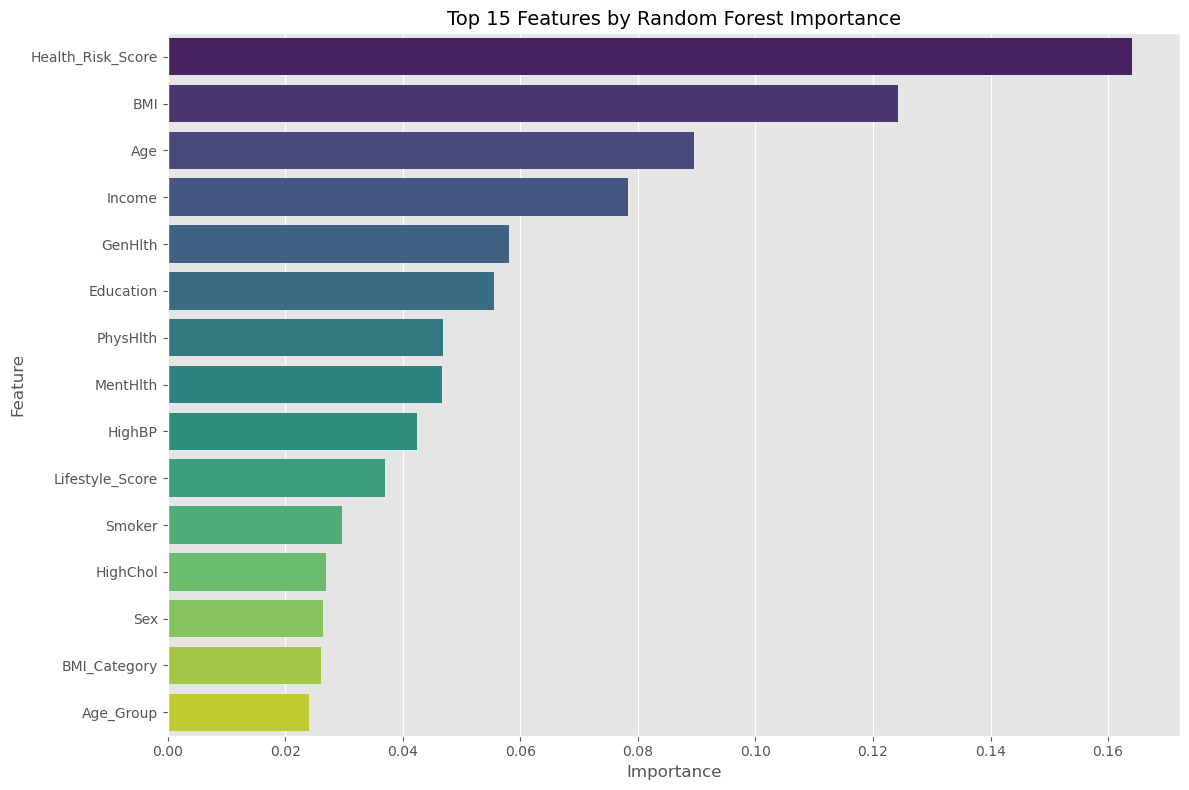

In [12]:

# Prepare data for feature importance analysis
# Separate features and target
X = df.drop(['Diabetes_binary', 'BMI_original'], axis=1)  # Drop target and original BMI
y = df['Diabetes_binary']

# Train a Random Forest classifier
print("Training Random Forest for feature importance...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest Feature Importances:")
print(feature_importances.head(15))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='viridis')
plt.title('Top 15 Features by Random Forest Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()


### 5.3 Multiple Feature Selection Methods


1. Calculating mutual information scores...
Mutual Information Scores (top 10):
              Feature  MI_Score
23  Health_Risk_Score  0.139400
13            GenHlth  0.089942
0              HighBP  0.078107
3                 BMI  0.055901
1            HighChol  0.047340
18                Age  0.044814
21       BMI_Category  0.044720
16           DiffWalk  0.039067
22          Age_Group  0.038850
15           PhysHlth  0.026547

2. Applying Chi-squared feature selection...
Chi-squared Scores (top 10):
              Feature    Chi2_Score
15           PhysHlth  51098.955612
23  Health_Risk_Score  15347.109028
3                 BMI   9267.347588
14           MentHlth   7932.199681
18                Age   4942.574718
13            GenHlth   4655.400614
0              HighBP   4098.597683
16           DiffWalk   3652.087005
20             Income   2620.241677
1            HighChol   2562.835375

3. Calculating permutation importance...
Permutation Importance Scores (top 10):
              F

<Figure size 1500x1000 with 0 Axes>

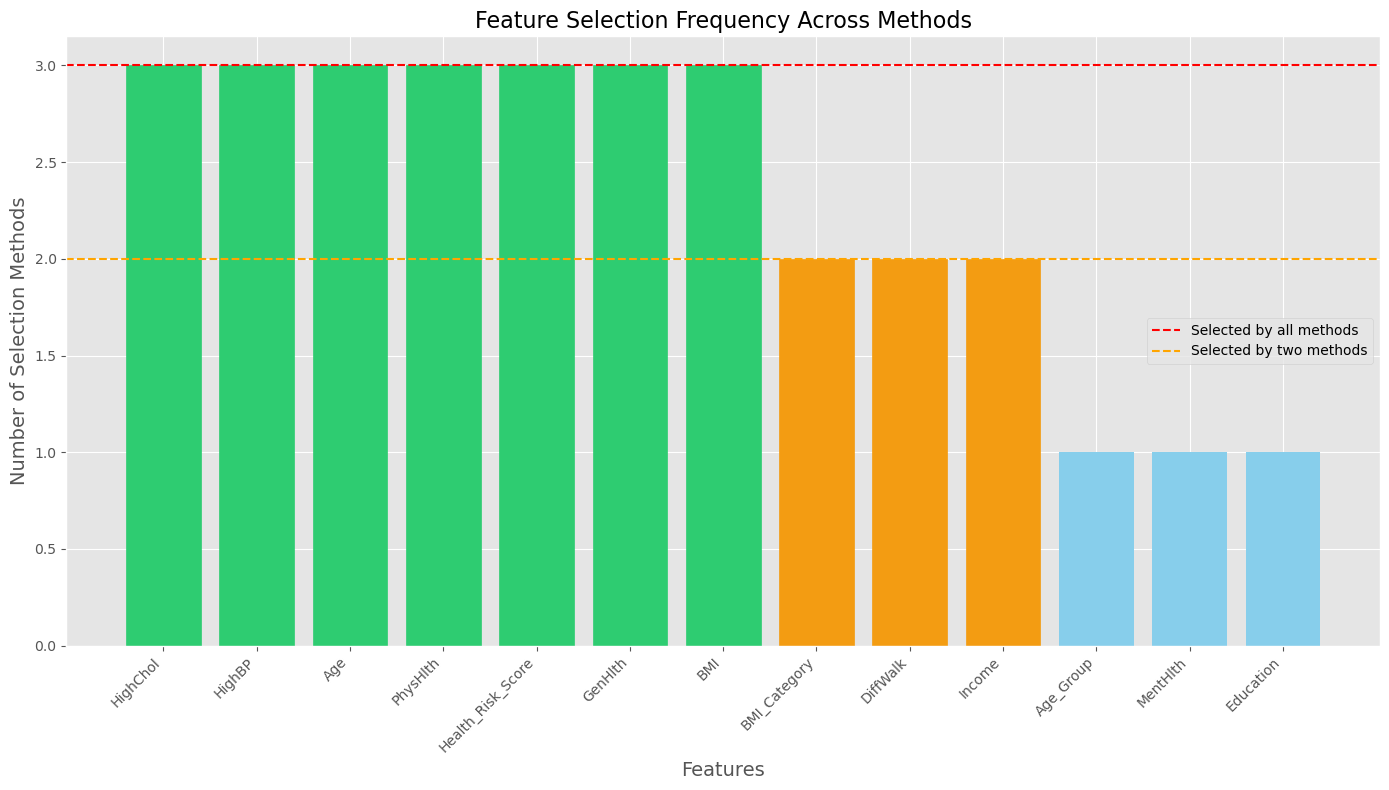


Features selected by all three methods:
- HighChol
- HighBP
- Age
- PhysHlth
- Health_Risk_Score
- GenHlth
- BMI

Top 15 features by average rank across all methods:
                 Feature  MI_Rank  Chi2_Rank  Perm_Rank   Avg_Rank
23     Health_Risk_Score      1.0        2.0        1.0   1.333333
3                    BMI      4.0        3.0        2.0   3.000000
13               GenHlth      2.0        6.0        4.0   4.000000
18                   Age      6.0        5.0        3.0   4.666667
0                 HighBP      3.0        7.0        6.0   5.333333
15              PhysHlth     10.0        1.0        9.0   6.666667
1               HighChol      5.0       10.0        8.0   7.666667
20                Income     11.0        9.0        5.0   8.333333
21          BMI_Category      7.0       12.0       10.0   9.666667
16              DiffWalk      8.0        8.0       16.0  10.666667
22             Age_Group      9.0       13.0       14.0  12.000000
19             Education     

In [13]:

# Apply multiple feature selection methods for a more robust selection

# 1. Mutual Information (already implemented)
print("1. Calculating mutual information scores...")
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_results = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("Mutual Information Scores (top 10):")
print(mi_results.head(10))

# 2. Chi-squared test (works well for categorical features)
print("\n2. Applying Chi-squared feature selection...")
# Convert negative values to 0 for chi2 (it requires non-negative values)
X_chi = X.copy()
for col in X_chi.columns:
    if X_chi[col].min() < 0:
        X_chi[col] = X_chi[col] - X_chi[col].min()

# Apply chi-squared feature selection
chi2_selector = SelectKBest(chi2, k=15)
chi2_selector.fit(X_chi, y)
chi2_scores = chi2_selector.scores_

chi2_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2_Score': chi2_scores
}).sort_values('Chi2_Score', ascending=False)

print("Chi-squared Scores (top 10):")
print(chi2_results.head(10))

# 3. Permutation Importance (more reliable than standard feature importance)
print("\n3. Calculating permutation importance...")
# Use a small subset for faster computation if dataset is large
if len(X) > 10000:
    X_sample = X.sample(10000, random_state=42)
    y_sample = y.loc[X_sample.index]
    perm_importance = permutation_importance(rf, X_sample, y_sample, 
                                           n_repeats=5, random_state=42)
else:
    perm_importance = permutation_importance(rf, X, y, 
                                           n_repeats=5, random_state=42)

# Extract mean importance values
perm_importance_values = perm_importance['importances_mean']

perm_results = pd.DataFrame({
    'Feature': X.columns,
    'Perm_Importance': perm_importance_values
}).sort_values('Perm_Importance', ascending=False)

print("Permutation Importance Scores (top 10):")
print(perm_results.head(10))

# Create a plot comparing the different feature selection methods
plt.figure(figsize=(15, 10))

# Get top 10 features from each method
top_mi = set(mi_results.head(10)['Feature'])
top_chi2 = set(chi2_results.head(10)['Feature'])
top_perm = set(perm_results.head(10)['Feature'])

# Find features that appear in multiple methods
common_features = list(top_mi.intersection(top_chi2).intersection(top_perm))
mi_chi2 = list(top_mi.intersection(top_chi2) - set(common_features))
mi_perm = list(top_mi.intersection(top_perm) - set(common_features))
chi2_perm = list(top_chi2.intersection(top_perm) - set(common_features))

# Create a bar chart showing feature selection frequency
all_features = pd.Series(list(top_mi) + list(top_chi2) + list(top_perm))
feature_counts = all_features.value_counts().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(feature_counts)), feature_counts.values.tolist(), color='skyblue')
plt.axhline(y=3, color='r', linestyle='--', label='Selected by all methods')
plt.axhline(y=2, color='orange', linestyle='--', label='Selected by two methods')
plt.xticks(range(len(feature_counts)), feature_counts.index.tolist())

# Highlight bars by color based on count
for i, count in enumerate(feature_counts.values):
    if count == 3:
        bars[i].set_color('#2ecc71')  # Green for features selected by all methods
    elif count == 2:
        bars[i].set_color('#f39c12')  # Orange for features selected by two methods

plt.title('Feature Selection Frequency Across Methods', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Number of Selection Methods', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Create a combined feature ranking
print("\nFeatures selected by all three methods:")
for feature in common_features:
    print(f"- {feature}")

# Combine the rankings from all methods
all_rankings = pd.DataFrame({
    'Feature': X.columns,
    'MI_Rank': mi_results['MI_Score'].rank(ascending=False),
    'Chi2_Rank': chi2_results['Chi2_Score'].rank(ascending=False),
    'Perm_Rank': perm_results['Perm_Importance'].rank(ascending=False)
})

all_rankings['Avg_Rank'] = (all_rankings['MI_Rank'] + 
                           all_rankings['Chi2_Rank'] + 
                           all_rankings['Perm_Rank']) / 3

all_rankings = all_rankings.sort_values('Avg_Rank')
print("\nTop 15 features by average rank across all methods:")
print(all_rankings.head(15))


### 5.4 Select Final Feature Set


In [14]:

# Based on our analysis, select the most important features
print("Selecting final feature set...")

# Combine results from correlation and random forest importance
feature_selection = pd.DataFrame({
    'Feature': X.columns,
    'Correlation': [abs(correlations.get(col, 0)) for col in X.columns],
    'RF_Importance': rf.feature_importances_
})

# Calculate average score
feature_selection['Avg_Score'] = (
    feature_selection['Correlation'] / feature_selection['Correlation'].max() + 
    feature_selection['RF_Importance'] / feature_selection['RF_Importance'].max()
) / 2

# Sort by average score
feature_selection = feature_selection.sort_values('Avg_Score', ascending=False)
print("Feature ranking:")
print(feature_selection.head(15))

# Select top features 
top_features = feature_selection.head(15)['Feature'].tolist()
print("\nSelected top features:")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}")

# Create final feature set
X_selected = df[top_features]


Selecting final feature set...
Feature ranking:
                 Feature  Correlation  RF_Importance  Avg_Score
23     Health_Risk_Score     0.463956       0.164040   1.000000
3                    BMI     0.304231       0.124307   0.706758
13               GenHlth     0.396571       0.058115   0.604518
18                   Age     0.274550       0.089531   0.568773
0                 HighBP     0.372048       0.042344   0.530017
20                Income     0.212846       0.078383   0.468295
21          BMI_Category     0.290867       0.026083   0.392966
1               HighChol     0.281399       0.026903   0.385262
15              PhysHlth     0.206868       0.046811   0.365622
22             Age_Group     0.270581       0.024031   0.364848
16              DiffWalk     0.267082       0.018062   0.342885
19             Education     0.158522       0.055534   0.340109
6   HeartDiseaseorAttack     0.207229       0.010701   0.255944
14              MentHlth     0.080688       0.046620   0

## 6. Data Scaling and Train-Test Split



### 6.1 Prepare Final Dataset


In [15]:

# Add target variable to selected features
final_df = X_selected.copy()
final_df['Diabetes_binary'] = y

# Display final dataset
print("Final dataset shape:", final_df.shape)
print("Final dataset columns:", final_df.columns.tolist())
final_df.head()


Final dataset shape: (69057, 16)
Final dataset columns: ['Health_Risk_Score', 'BMI', 'GenHlth', 'Age', 'HighBP', 'Income', 'BMI_Category', 'HighChol', 'PhysHlth', 'Age_Group', 'DiffWalk', 'Education', 'HeartDiseaseorAttack', 'MentHlth', 'Lifestyle_Score', 'Diabetes_binary']


,Health_Risk_Score,BMI,GenHlth,Age,HighBP,Income,BMI_Category,HighChol,PhysHlth,Age_Group,DiffWalk,Education,HeartDiseaseorAttack,MentHlth,Lifestyle_Score,Diabetes_binary
0,2.500000,26.0,3.0,4.0,1.0,8.0,2,0.0,30.0,1,0.0,6.0,0.0,5.0,3.0,0.0
1,2.500000,26.0,3.0,12.0,1.0,8.0,2,1.0,0.0,3,0.0,6.0,0.0,0.0,2.0,0.0
2,0.333333,26.0,1.0,13.0,0.0,8.0,2,0.0,10.0,3,0.0,6.0,0.0,0.0,4.0,0.0
3,2.600000,28.0,3.0,11.0,1.0,8.0,2,1.0,3.0,3,0.0,6.0,0.0,0.0,4.0,0.0
4,0.250000,29.0,2.0,8.0,0.0,8.0,2,0.0,0.0,2,0.0,5.0,0.0,0.0,4.0,0.0


### 6.2 Train-Test Split


In [16]:

# Split the data into training and testing sets
print("Performing train-test split...")

# Use stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Verify class distribution in splits
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print("Training set class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))
print("Testing set class distribution:")
print(pd.Series(y_test).value_counts(normalize=True))


Performing train-test split...
Training set size: 55245
Testing set size: 13812
Training set class distribution:
Diabetes_binary
1.0    0.508227
0.0    0.491773
Name: proportion, dtype: float64
Testing set class distribution:
Diabetes_binary
1.0    0.508254
0.0    0.491746
Name: proportion, dtype: float64


### 6.3 Feature Scaling


Scaling numerical features...
Found numerical features to scale: ['BMI', 'PhysHlth', 'MentHlth', 'Health_Risk_Score', 'Age']

1. Applying StandardScaler...

BMI before StandardScaler:
  Train - Mean: 29.84, Std: 6.58
  Test  - Mean: 29.78, Std: 6.58

BMI after StandardScaler:
  Train - Mean: 0.00, Std: 1.00
  Test  - Mean: -0.01, Std: 1.00

2. Applying MinMaxScaler...

BMI after MinMaxScaler:
  Train - Min: 0.00, Max: 1.00
  Test  - Min: -0.03, Max: 1.00


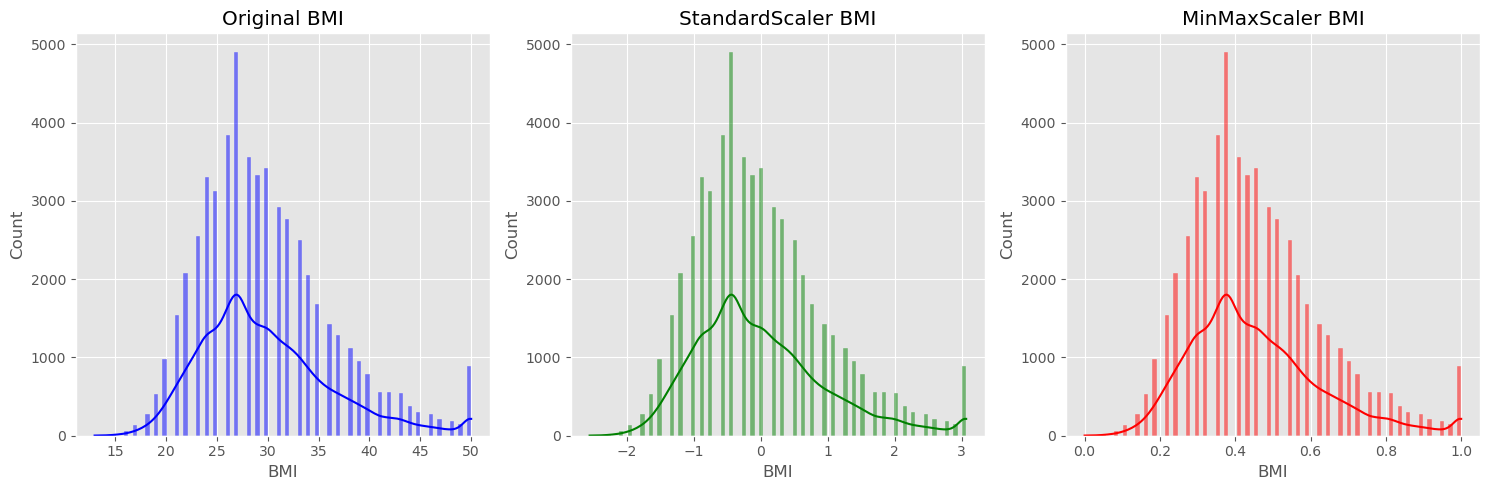


Scaling complete. Both StandardScaler and MinMaxScaler versions are available.
Note: For tree-based models like Random Forest, scaling is not required
      For SVM, Neural Networks, and k-NN, scaling is important for performance


In [17]:

# Scale numerical features for algorithms sensitive to feature scale
print("Scaling numerical features...")

# Identify numerical features that need scaling
numerical_features = ['BMI', 'PhysHlth', 'MentHlth', 'Health_Risk_Score', 'Age']
numerical_features = [f for f in numerical_features if f in X_train.columns]

if numerical_features:
    print(f"Found numerical features to scale: {numerical_features}")
    
    # Create copies of training and test sets for scaling
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    # 1. StandardScaler (mean=0, std=1)
    print("\n1. Applying StandardScaler...")
    std_scaler = StandardScaler()
    
    # Apply to numerical features
    for col in numerical_features:
        # Reshape for scikit-learn compatibility
        X_train_col = X_train[col].values.reshape(-1, 1)
        X_test_col = X_test[col].values.reshape(-1, 1)
        
        # Fit on training data, transform both training and test
        X_train_scaled[col] = std_scaler.fit_transform(X_train_col).flatten()
        X_test_scaled[col] = std_scaler.transform(X_test_col).flatten()
    
    # Show before and after comparison for a sample feature
    if 'BMI' in numerical_features:
        print("\nBMI before StandardScaler:")
        print(f"  Train - Mean: {X_train['BMI'].mean():.2f}, Std: {X_train['BMI'].std():.2f}")
        print(f"  Test  - Mean: {X_test['BMI'].mean():.2f}, Std: {X_test['BMI'].std():.2f}")
        
        print("\nBMI after StandardScaler:")
        print(f"  Train - Mean: {X_train_scaled['BMI'].mean():.2f}, Std: {X_train_scaled['BMI'].std():.2f}")
        print(f"  Test  - Mean: {X_test_scaled['BMI'].mean():.2f}, Std: {X_test_scaled['BMI'].std():.2f}")
    
    # 2. MinMaxScaler (scales to range [0,1])
    print("\n2. Applying MinMaxScaler...")
    X_train_minmax = X_train.copy()
    X_test_minmax = X_test.copy()
    
    minmax_scaler = MinMaxScaler()
    
    # Apply to numerical features
    for col in numerical_features:
        # Reshape for scikit-learn compatibility
        X_train_col = X_train[col].values.reshape(-1, 1)
        X_test_col = X_test[col].values.reshape(-1, 1)
        
        # Fit on training data, transform both training and test
        X_train_minmax[col] = minmax_scaler.fit_transform(X_train_col).flatten()
        X_test_minmax[col] = minmax_scaler.transform(X_test_col).flatten()
    
    # Show before and after comparison for a sample feature
    if 'BMI' in numerical_features:
        print("\nBMI after MinMaxScaler:")
        print(f"  Train - Min: {X_train_minmax['BMI'].min():.2f}, Max: {X_train_minmax['BMI'].max():.2f}")
        print(f"  Test  - Min: {X_test_minmax['BMI'].min():.2f}, Max: {X_test_minmax['BMI'].max():.2f}")
    
    # Compare distributions visually
    if 'BMI' in numerical_features:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        sns.histplot(X_train['BMI'], kde=True, color='blue')
        plt.title('Original BMI')
        
        plt.subplot(1, 3, 2)
        sns.histplot(X_train_scaled['BMI'], kde=True, color='green')
        plt.title('StandardScaler BMI')
        
        plt.subplot(1, 3, 3)
        sns.histplot(X_train_minmax['BMI'], kde=True, color='red')
        plt.title('MinMaxScaler BMI')
        
        plt.tight_layout()
        plt.show()
        
    print("\nScaling complete. Both StandardScaler and MinMaxScaler versions are available.")
    print("Note: For tree-based models like Random Forest, scaling is not required")
    print("      For SVM, Neural Networks, and k-NN, scaling is important for performance")
else:
    print("No numerical features to scale.")


## 7. Save Processed Data


In [18]:

# Save the preprocessed data for modeling
print("Saving preprocessed data...")

# Import pickle if not already imported
import pickle
import os

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Create dictionaries to save
preprocessed_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': top_features,
    'selected_features': top_features,
    'feature_rankings': all_rankings,
    'feature_importances': {
        'mutual_info': mi_results,
        'chi2': chi2_results,
        'permutation': perm_results
    }
}

# Save using pickle
with open('data/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

print("Preprocessed data saved to 'data/preprocessed_data.pkl'")

# Save scaled versions if they exist
try:
    if 'X_train_scaled' in locals() and 'X_test_scaled' in locals():
        scaled_data = {
            'X_train_std': X_train_scaled,
            'X_test_std': X_test_scaled,
            'X_train_minmax': X_train_minmax,
            'X_test_minmax': X_test_minmax,
            'y_train': y_train,
            'y_test': y_test,
            'feature_names': top_features,
            'numerical_features': numerical_features
        }
        
        with open('data/scaled_data.pkl', 'wb') as f:
            pickle.dump(scaled_data, f)
            
        print("Scaled data saved to 'data/scaled_data.pkl'")
except Exception as e:
    print(f"Note: Could not save scaled data. Error: {e}")

print("Data preprocessing complete! Ready for model development!")


Saving preprocessed data...
Preprocessed data saved to 'data/preprocessed_data.pkl'
Scaled data saved to 'data/scaled_data.pkl'
Data preprocessing complete! Ready for model development!


## 8. Summary

### Data Preprocessing Results:

1. **Dataset Structure**:
   - Performed comprehensive data quality check (missing values, duplicates, outliers)
   - Handled BMI outliers by capping values at 50
   - Maintained balanced dataset with equal class distribution (50% diabetes, 50% non-diabetes)

2. **Feature Engineering**:
   - Created BMI categories (Underweight, Normal, Overweight, Obese)
   - Created age groups (18-29, 30-49, 50-64, 65+)
   - Developed a Health Risk Score combining multiple health indicators
   - Developed a Lifestyle Score combining activity and diet factors

3. **Feature Selection**:
   - Applied multiple feature selection methods:
     - Correlation analysis
     - Random Forest feature importance
     - Chi-squared test (SelectKBest)
     - Mutual Information
     - Permutation Importance
   - Combined rankings from all methods for robust feature selection
   - Identified features consistently selected across multiple methods

4. **Data Preparation**:
   - Performed stratified train-test split (80% train, 20% test)
   - Maintained class balance in both training and testing sets
   - Applied multiple scaling techniques:
     - StandardScaler (mean=0, std=1)
     - MinMaxScaler (range [0,1])
   - Saved both original and scaled versions of the data

5. **Outputs**:
   - Preprocessed data saved to pickle files
   - Feature importance rankings from multiple methods
   - Scaled datasets ready for different algorithm types

The preprocessed data is now ready for model development, with appropriate versions for both tree-based models (original data) and distance/gradient-based models (scaled data).
